In [ ]:
import os
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy import misc
from transform_label import label

root = os.pardir+os.sep+"car"+os.sep
list_image = []
list_label = []
#三通道转为一通道灰度图
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

#图片二值化并且统一成24*48
def pic(file):
    ppic = mpimg.imread(file)
    ppic = rgb2gray(ppic)
    tmppic = misc.imresize(ppic, (48, 24))
    mean = np.mean(tmppic)
    for i in range(tmppic.shape[0]):
        for j in range(tmppic.shape[1]):
            if tmppic[i][j] > mean:
                tmppic[i][j] = 1
            else:
                tmppic[i][j] = 0
    return tmppic

for rt, dirs, files in os.walk(root):
    for f in files:
        p, lab = os.path.split(rt)
        img = pic(rt + "\\" + f).reshape(1152)
        biaoqian = label[lab]
        list_image.append(img)
        list_label.append(biaoqian)
print(len(list_label))

list_data = [[a, b] for a, b in zip(list_image, list_label)]
random.shuffle(list_data)

with tf.python_io.TFRecordWriter('train.tfrecord') as writer:
    for i in range(17447):
        images = tf.train.Feature(int64_list=tf.train.Int64List(value=list_data[i][0]))
        print(list_data[i][1])
        labels = tf.train.Feature(int64_list=tf.train.Int64List(value=[list_data[i][1]]))
        features = tf.train.Features(feature={'labels': labels, 'images': images})
        example = tf.train.Example(features=features)
        writer.write(example.SerializeToString())


with tf.python_io.TFRecordWriter('test.tfrecord') as writer:
    for i in range(17447,18447):
        images = tf.train.Feature(int64_list=tf.train.Int64List(value=list_data[i][0]))
        print(list_data[i][1])
        labels = tf.train.Feature(int64_list=tf.train.Int64List(value=[list_data[i][1]]))
        features = tf.train.Features(feature={'labels': labels, 'images': images})
        example = tf.train.Example(features=features)
        writer.write(example.SerializeToString())

In [ ]:
import tensorflow as tf
import numpy as np

class license(object):

    def __init__(self, tfrecord_fileename, num):
        filename_queue = tf.train.string_input_producer([tfrecord_fileename])
        reader = tf.TFRecordReader()
        key, value = reader.read(filename_queue)
        features = tf.parse_single_example(
            value,
            features={
                'images': tf.FixedLenFeature([1, 1152], tf.int64),
                'labels': tf.FixedLenFeature([], tf.int64)
            })
        images = features['images']
        labels = features['labels']
        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
        self._images = np.zeros((num, 1152))
        self._labels = np.zeros((num, 68))
        with tf.Session() as sess:
            sess.run(init_op)
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(coord=coord)

            for i in range(num):
                imgs, labs = sess.run([images, labels])
                self._images[i] = imgs
                if labs == 52:
                    self._labels[i][labs] = 0.97
                else:
                    self._labels[i][labs] = 1.0

            coord.request_stop()
            coord.join(threads)

        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = num

    def next_batch(self, batch_size):
        start = self._index_in_epoch

        if start + batch_size > self._num_examples:
            self._epochs_completed += 1
            rest_num_examples = self._num_examples-start
            images_rest_part = self._images[start:self._num_examples,:]
            labels_rest_part = self._labels[start:self._num_examples,:]

            start = 0

            self._index_in_epoch = batch_size - rest_num_examples
            end = self._index_in_epoch
            images_new_part = self._images[start:end,:]
            labels_new_part = self._labels[start:end,:]
            return np.concatenate((images_rest_part, images_new_part), axis=0), np.concatenate(
                (labels_rest_part, labels_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._images[start:end,:], self._labels[start:end,:]

In [1]:
import tensorflow as tf
from readTFrecord import license

train = license('train.tfrecord', 17447)
test = license('test.tfrecord', 1000)

# 一，函数声明部分

def weight_variable(shape):
    # 正态分布，标准差为0.1，默认最大为1，最小为-1，均值为0
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    # 创建一个结构为shape矩阵也可以说是数组shape声明其行列，初始化所有值为0.1
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, w):
    # 卷积遍历各方向步数为1，SAME：边缘外自动补0，遍历相乘
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    # 池化卷积结果（conv2d）池化层采用kernel大小为2*2，步数也为2，周围补0，取最大值。数据量缩小了4倍
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def prelu(_x, scope=None):
    """parametric ReLU activation"""
    with tf.variable_scope(name_or_scope=scope, default_name="prelu"):
        _alpha = tf.get_variable("prelu", shape=_x.get_shape()[-1],
                                 dtype=_x.dtype, initializer=tf.constant_initializer(0.9))
        return tf.maximum(0.0, _x) + _alpha * tf.minimum(0.0, _x)

# 二，定义输入输出结构

# 声明一个占位符，None表示输入图片的数量不定，48*24图片分辨率
xs = tf.placeholder(tf.float32, [None, 1152])
# 类别是0-67总共68个类别，对应输出分类结果
ys = tf.placeholder(tf.float32, [None, 68])
with tf.name_scope("reshape"):
    # x_image又把xs reshape成了48*24*1的形状，因为是灰色图片，所以通道是1.作为训练时的input，-1代表图片数量不定
    x_image = tf.reshape(xs, [-1, 48, 24, 1])

# 三，搭建网络,定义算法公式，也就是forward时的计算
with tf.name_scope("conv1"):
    # 第一层卷积操作
    # 第一二参数值得卷积核尺寸大小，即patch，第三个参数是图像通道数，第四个参数是卷积核的数目，代表会出现多少个卷积特征图像;
    W_conv1 = weight_variable([3, 3, 1, 48])
    # 对于每一个卷积核都有一个对应的偏置量。
    b_conv1 = bias_variable([48])
    # 图片乘以卷积核，并加上偏执量，卷积结果48x24x32
    h_conv1 = prelu(conv2d(x_image, W_conv1) + b_conv1)
with tf.name_scope("pool1"):
    # 池化结果24x12x32 卷积结果乘以池化卷积核
    h_pool1 = max_pool_2x2(h_conv1)
with tf.name_scope("conv2"):
    # 第二层卷积操作
    # 32通道卷积，卷积出64个特征
    w_conv2 = weight_variable([3, 3, 48, 96])
    # 64个偏执数据
    b_conv2 = bias_variable([96])
    # 注意h_pool1是上一层的池化结果，#卷积结果24x12x64
    h_conv2 = prelu(conv2d(h_pool1, w_conv2) + b_conv2)
with tf.name_scope("pool2"):
    # 池化结果12x6x64
    h_pool2 = max_pool_2x2(h_conv2)
    # 原图像尺寸48*24，第一轮图像缩小为24*12，共有32张，第二轮后图像缩小为12*6，共有64张
with tf.name_scope("conv3"):
    w_conv3 = weight_variable([3, 3, 96, 144])
    b_conv3 = bias_variable([144])
    h_conv3 = prelu(conv2d(h_pool2,w_conv3) + b_conv3)
with tf.name_scope("pool3"):
    h_pool3 = max_pool_2x2(h_conv3)
with tf.name_scope("fc1"):
    # 第三层全连接操作
    # 二维张量，第一个参数12*6*64的patch，也可以认为是只有一行12*6*64个数据的卷积，第二个参数代表卷积个数共1024个
    W_fc1 = weight_variable([6 * 3 * 144, 1024])
    # 1024个偏执数据
    b_fc1 = bias_variable([1024])
    # 将第二层卷积池化结果reshape成只有一行12*6*64个数据# [n_samples, 12, 6, 64] ->> [n_samples, 12*6*64]
    h_pool2_flat = tf.reshape(h_pool3, [-1, 6 * 3 * 144])
    # 卷积操作，结果是1*1*1024，单行乘以单列等于1*1矩阵，matmul实现最基本的矩阵相乘，不同于tf.nn.conv2d的遍历相乘，自动认为是前行向量后列向量
    h_fc1 = prelu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
with tf.name_scope("dropout"):
    keep_prob = tf.placeholder(tf.float32)
    # dropout操作，减少过拟合，其实就是降低上一层某些输入的权重scale，甚至置为0，升高某些输入的权值，甚至置为2，防止评测曲线出现震荡，个人觉得样本较少时很必要
    # 使用占位符，由dropout自动确定scale，也可以自定义，比如0.5，根据tensorflow文档可知，程序中真实使用的值为1/0.5=2，也就是某些输入乘以2，同时某些输入乘以0
    h_fc2_drop = tf.nn.dropout(h_fc1, keep_prob)  # 对卷积结果执行dropout操作
with tf.name_scope("fc3"):
    # 第四层输出操作
    # 二维张量，1*1024矩阵卷积，共10个卷积，对应我们开始的ys长度为10
    W_fc3 = weight_variable([1024, 68])
    b_fc3 = bias_variable([68])
    # 最后的分类，结果为1*1*10 softmax和sigmoid都是基于logistic分类算法，一个是多分类一个是二分类
    # y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)
    y_conv=tf.matmul(h_fc2_drop, W_fc3) + b_fc3
with tf.name_scope("loss"):
    # 四，定义loss(最小误差概率)，选定优化优化loss，
    # cross_entropy = -tf.reduce_sum(ys * tf.log(y_conv))  # 定义交叉熵为loss函数
    cross_entropy=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_conv,labels=tf.argmax(ys,1)))
with tf.name_scope("Adam_optimizer"):
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)  # 调用优化器优化，其实就是通过喂数据争取cross_entropy最小化
    # GradientDescentOptimizer AdamOptimizer
label_predict=tf.argmax(y_conv,1)
# 五，开始数据训练以及评测
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(ys, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# train_writer = tf.summary.FileWriter('graphs/')
# train_writer.add_graph(tf.get_default_graph())
saver = tf.train.Saver()
test = test.next_batch(1000)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(2000):
        batch = train.next_batch(batch_size=50)
        if i % 100 == 0:
            # print(batch[1][0])
            # print(sess.run(label_predict, feed_dict={xs: batch[0], ys: batch[1], keep_prob: 0.5})[0])
            train_accuracy = accuracy.eval(feed_dict={xs: test[0], ys: test[1], keep_prob: 1.0})
            print("step %d, 验证集的正确率 %g" % (i, train_accuracy))
        train_step.run(feed_dict={xs: batch[0], ys: batch[1], keep_prob: 0.5})

    saver.save(sess, 'saved_model/lu0.97/model.ckpt')

    print("该模型的正确率为 %g" % accuracy.eval(feed_dict={xs: test[0], ys: test[1], keep_prob: 1.0}))

step 0, 验证集的正确率 0.001
step 100, 验证集的正确率 0.91
step 200, 验证集的正确率 0.95
step 300, 验证集的正确率 0.966
step 400, 验证集的正确率 0.968
step 500, 验证集的正确率 0.974
step 600, 验证集的正确率 0.986
step 700, 验证集的正确率 0.981
step 800, 验证集的正确率 0.986
step 900, 验证集的正确率 0.984
step 1000, 验证集的正确率 0.987
step 1100, 验证集的正确率 0.978
step 1200, 验证集的正确率 0.984
step 1300, 验证集的正确率 0.985
step 1400, 验证集的正确率 0.978
step 1500, 验证集的正确率 0.985
step 1600, 验证集的正确率 0.989
step 1700, 验证集的正确率 0.983
step 1800, 验证集的正确率 0.985
step 1900, 验证集的正确率 0.979
该模型的正确率为 0.976


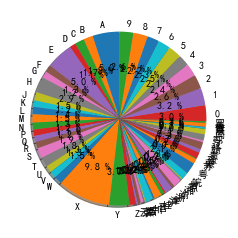

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os


plt.rcParams['font.sans-serif'] = ['SimHei']
root = os.pardir+os.sep+"car"+os.sep
dict_num = {}
for rt, dirs, files in os.walk(root):
    for f in files:
        p, lab = os.path.split(rt)
        if dict_num.get(lab) != None:
            dict_num[lab]+=1
        else:
            dict_num[lab]=0

labels = dict_num.keys()
fracs = [a/sum(dict_num.values()) for a in list(dict_num.values())]
explode = np.zeros(len(dict_num.keys()))
plt.axes(aspect=1)
plt.pie(x=fracs, labels=labels, explode=explode, autopct='%3.1f %%',
        shadow=True, labeldistance=1.1, startangle=90, pctdistance=0.6)
plt.show()

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '云', '京', '冀', '吉', '宁', '川', '晋', '桂', '沪', '津', '浙', '渝', '湘', '琼', '甘', '皖', '粤', '苏', '蒙', '豫', '贵', '赣', '辽', '鄂', '闽', '陕', '青', '鲁', '黑', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
dict_values([917, 324, 318, 209, 920, 245, 227, 535, 283, 218, 254, 282, 239, 219, 204, 223, 353, 323, 238, 238, 269, 1809, 688, 219, 64, 104, 102, 43, 30, 259, 58, 257, 113, 52, 263, 94, 291, 43, 34, 247, 395, 166, 27, 215, 123, 245, 63, 211, 185, 54, 23, 135, 50, 544, 591, 479, 439, 381, 453, 424, 407, 495, 471])
{'A': 917, 'B': 324, 'C': 318, 'D': 209, 'E': 920, 'F': 245, 'G': 227, 'H': 535, 'J': 283, 'K': 218, 'L': 254, 'M': 282, 'N': 239, 'P': 219, 'Q': 204, 'R': 223, 'S': 353, 'T': 323, 'U': 238, 'V': 238, 'W': 269, 'X': 1809, 'Y': 688, 'Z': 219, '云': 64, '京': 104, '冀': 102, '吉': 43, '宁': 30, '川': 259, '晋': 58, '桂': 257, '沪': 113, '津': 52, '浙': 263, '渝': 94, '湘': 291, '

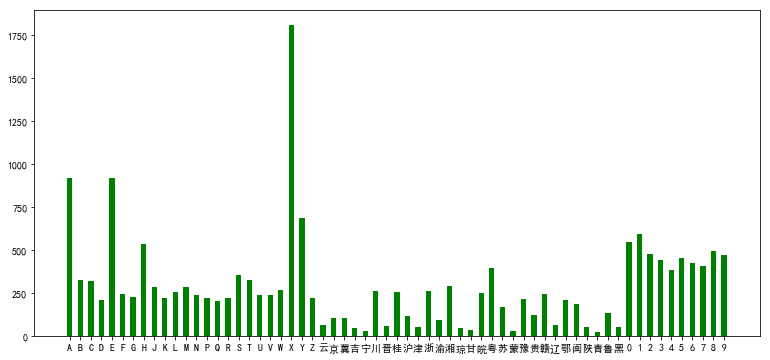

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

plt.rcParams['font.sans-serif'] = ['SimHei']
root = os.pardir+os.sep+"car"+os.sep
dict_num = {}
for rt, dirs, files in os.walk(root):
    for f in files:
        p, lab = os.path.split(rt)
        if dict_num.get(lab) != None:
            dict_num[lab]+=1
        else:
            dict_num[lab]=0
print(list(dict_num.keys()))
print(dict_num.values())
print(dict_num)
idx = np.arange(len(list(dict_num.keys())))
plt.figure(figsize=(13,6))
plt.bar(idx, list(dict_num.values()), 0.5, color='green')
plt.xticks(idx, list(dict_num.keys()))
plt.show()

# 原数据集

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @File  : valid_cnn.py
# @Author: Joker
# @Date  : 2017/12/6

import tensorflow as tf
from readTFrecord import license
import os
import matplotlib.image as mpimg
import numpy as np
from scipy import misc
from transform_label import label

test = license('test.tfrecord', 1000)
# 一，函数声明部分

def weight_variable(shape):
    # 正态分布，标准差为0.1，默认最大为1，最小为-1，均值为0
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    # 创建一个结构为shape矩阵也可以说是数组shape声明其行列，初始化所有值为0.1
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, w):
    # 卷积遍历各方向步数为1，SAME：边缘外自动补0，遍历相乘
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    # 池化卷积结果（conv2d）池化层采用kernel大小为2*2，步数也为2，周围补0，取最大值。数据量缩小了4倍
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def prelu(_x, scope=None):
    """parametric ReLU activation"""
    with tf.variable_scope(name_or_scope=scope, default_name="prelu"):
        _alpha = tf.get_variable("prelu", shape=_x.get_shape()[-1],
                                 dtype=_x.dtype, initializer=tf.constant_initializer(0.5))
        return tf.maximum(0.0, _x) + _alpha * tf.minimum(0.0, _x)

# 二，定义输入输出结构

# 声明一个占位符，None表示输入图片的数量不定，48*24图片分辨率
xs = tf.placeholder(tf.float32, [None, 1152])
# 类别是0-67总共68个类别，对应输出分类结果
ys = tf.placeholder(tf.float32, [None, 68])
with tf.name_scope("reshape"):
    # x_image又把xs reshape成了48*24*1的形状，因为是灰色图片，所以通道是1.作为训练时的input，-1代表图片数量不定
    x_image = tf.reshape(xs, [-1, 48, 24, 1])

# 三，搭建网络,定义算法公式，也就是forward时的计算
with tf.name_scope("conv1"):
    # 第一层卷积操作
    # 第一二参数值得卷积核尺寸大小，即patch，第三个参数是图像通道数，第四个参数是卷积核的数目，代表会出现多少个卷积特征图像;
    W_conv1 = weight_variable([3, 3, 1, 48])
    # 对于每一个卷积核都有一个对应的偏置量。
    b_conv1 = bias_variable([48])
    # 图片乘以卷积核，并加上偏执量，卷积结果48x24x32
    h_conv1 = prelu(conv2d(x_image, W_conv1) + b_conv1)
with tf.name_scope("pool1"):
    # 池化结果24x12x32 卷积结果乘以池化卷积核
    h_pool1 = max_pool_2x2(h_conv1)
with tf.name_scope("conv2"):
    # 第二层卷积操作
    # 32通道卷积，卷积出64个特征
    w_conv2 = weight_variable([3, 3, 48, 96])
    # 64个偏执数据
    b_conv2 = bias_variable([96])
    # 注意h_pool1是上一层的池化结果，#卷积结果24x12x64
    h_conv2 = prelu(conv2d(h_pool1, w_conv2) + b_conv2)
with tf.name_scope("pool2"):
    # 池化结果12x6x64
    h_pool2 = max_pool_2x2(h_conv2)
    # 原图像尺寸48*24，第一轮图像缩小为24*12，共有32张，第二轮后图像缩小为12*6，共有64张
with tf.name_scope("conv3"):
    w_conv3 = weight_variable([3, 3, 96, 144])
    b_conv3 = bias_variable([144])
    h_conv3 = prelu(conv2d(h_pool2,w_conv3) + b_conv3)
with tf.name_scope("pool3"):
    h_pool3 = max_pool_2x2(h_conv3)
with tf.name_scope("fc1"):
    # 第三层全连接操作
    # 二维张量，第一个参数12*6*64的patch，也可以认为是只有一行12*6*64个数据的卷积，第二个参数代表卷积个数共1024个
    W_fc1 = weight_variable([6 * 3 * 144, 1024])
    # 1024个偏执数据
    b_fc1 = bias_variable([1024])
    # 将第二层卷积池化结果reshape成只有一行12*6*64个数据# [n_samples, 12, 6, 64] ->> [n_samples, 12*6*64]
    h_pool2_flat = tf.reshape(h_pool3, [-1, 6 * 3 * 144])
    # 卷积操作，结果是1*1*1024，单行乘以单列等于1*1矩阵，matmul实现最基本的矩阵相乘，不同于tf.nn.conv2d的遍历相乘，自动认为是前行向量后列向量
    h_fc1 = prelu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
with tf.name_scope("dropout"):
    keep_prob = tf.placeholder(tf.float32)
    # dropout操作，减少过拟合，其实就是降低上一层某些输入的权重scale，甚至置为0，升高某些输入的权值，甚至置为2，防止评测曲线出现震荡，个人觉得样本较少时很必要
    # 使用占位符，由dropout自动确定scale，也可以自定义，比如0.5，根据tensorflow文档可知，程序中真实使用的值为1/0.5=2，也就是某些输入乘以2，同时某些输入乘以0
    h_fc2_drop = tf.nn.dropout(h_fc1, keep_prob)  # 对卷积结果执行dropout操作
with tf.name_scope("fc3"):
    # 第四层输出操作
    # 二维张量，1*1024矩阵卷积，共10个卷积，对应我们开始的ys长度为10
    W_fc3 = weight_variable([1024, 68])
    b_fc3 = bias_variable([68])
    # 最后的分类，结果为1*1*10 softmax和sigmoid都是基于logistic分类算法，一个是多分类一个是二分类
    # y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)
    y_conv=tf.matmul(h_fc2_drop, W_fc3) + b_fc3
with tf.name_scope("loss"):
    # 四，定义loss(最小误差概率)，选定优化优化loss，
    # cross_entropy = -tf.reduce_sum(ys * tf.log(y_conv))  # 定义交叉熵为loss函数
    cross_entropy=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_conv,labels=tf.argmax(ys,1)))
with tf.name_scope("Adam_optimizer"):
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)  # 调用优化器优化，其实就是通过喂数据争取cross_entropy最小化
    # GradientDescentOptimizer AdamOptimizer
label_predict=tf.argmax(y_conv,1)
# 五，开始数据训练以及评测
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(ys, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
test = test.next_batch(1000)


# 三通道转为一通道灰度图
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])


# 图片二值化并且统一成24*48
def pic(file):
    ppic = mpimg.imread(file)
    ppic = rgb2gray(ppic)
    tmppic = misc.imresize(ppic, (48, 24))
    mean = np.mean(tmppic)
    for i in range(tmppic.shape[0]):
        for j in range(tmppic.shape[1]):
            if tmppic[i][j] > mean:
                tmppic[i][j] = 1
            else:
                tmppic[i][j] = 0
    return tmppic

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.latest_checkpoint('saved_model/Adam')
    if ckpt:
        saver.restore(sess=sess, save_path=ckpt)

    root = os.pardir + os.sep + "car" + os.sep
    list_compare =['A', 'A']
    list_x = []
    list_y = []
    for rt, dirs, files in os.walk(root):
        for f in files:
            p, lab = os.path.split(rt)
            img = pic(rt + "\\" + f).reshape(1152)
            list_compare[0] = list_compare[1]
            list_compare[1] = lab
            if list_compare[0] == list_compare[1]:
                list_x.append(img)
                biaoqian = label[lab]
                tmp_label = np.zeros(68)
                tmp_label[biaoqian] = 1.0
                list_y.append(tmp_label)
            else:
                print(list_compare[0]+"的召回率 %g" % accuracy.eval(feed_dict={xs: list_x, ys: list_y, keep_prob: 1.0}))
                list_x = []
                list_y = []
                list_x.append(img)
                biaoqian = label[lab]
                tmp_label = np.zeros(68)
                tmp_label[biaoqian] = 1.0
                list_y.append(tmp_label)
    print(list_compare[1] + "的召回率 %g" % accuracy.eval(feed_dict={xs: list_x, ys: list_y, keep_prob: 1.0}))




    print("该模型的正确率为 %g" % accuracy.eval(feed_dict={xs: test[0], ys: test[1], keep_prob: 1.0}))

INFO:tensorflow:Restoring parameters from saved_model/Adam\model.ckpt


c:\users\zuoxin\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:136: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


A的召回率 0.997821
B的召回率 1
C的召回率 1
D的召回率 0.971429
E的召回率 0.998914
F的召回率 0.995935
G的召回率 0.995614
H的召回率 1
J的召回率 1
K的召回率 1
L的召回率 1
M的召回率 1
N的召回率 1
P的召回率 0.995455
Q的召回率 0.995122
R的召回率 1
S的召回率 1
T的召回率 0.996914
U的召回率 1
V的召回率 1
W的召回率 1
X的召回率 0.998895
Y的召回率 0.997097
Z的召回率 1
云的召回率 1
京的召回率 1
冀的召回率 1
吉的召回率 1
宁的召回率 1
川的召回率 1
晋的召回率 1
桂的召回率 1
沪的召回率 0.991228
津的召回率 1
浙的召回率 1
渝的召回率 0.978947
湘的召回率 0.996575
琼的召回率 1
甘的召回率 1
皖的召回率 1
粤的召回率 1
苏的召回率 1
蒙的召回率 1
豫的召回率 0.99537
贵的召回率 1
赣的召回率 1
辽的召回率 0.984375
鄂的召回率 1
闽的召回率 1
陕的召回率 1
青的召回率 1
鲁的召回率 0.845588
黑的召回率 1
0的召回率 0.998165
1的召回率 0.996622
2的召回率 0.995833
3的召回率 1
4的召回率 0.997382
5的召回率 0.997797
6的召回率 1
7的召回率 1
8的召回率 0.991935
9的召回率 1
该模型的正确率为 0.991


# 新数据集

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @File  : valid_cnn.py
# @Author: Joker
# @Date  : 2017/12/6

import tensorflow as tf
from readTFrecord import license
import os
import matplotlib.image as mpimg
import numpy as np
from scipy import misc
from transform_label import label

test = license('test.tfrecord', 5428)
# 一，函数声明部分

def weight_variable(shape):
    # 正态分布，标准差为0.1，默认最大为1，最小为-1，均值为0
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    # 创建一个结构为shape矩阵也可以说是数组shape声明其行列，初始化所有值为0.1
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, w):
    # 卷积遍历各方向步数为1，SAME：边缘外自动补0，遍历相乘
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    # 池化卷积结果（conv2d）池化层采用kernel大小为2*2，步数也为2，周围补0，取最大值。数据量缩小了4倍
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def prelu(_x, scope=None):
    """parametric ReLU activation"""
    with tf.variable_scope(name_or_scope=scope, default_name="prelu"):
        _alpha = tf.get_variable("prelu", shape=_x.get_shape()[-1],
                                 dtype=_x.dtype, initializer=tf.constant_initializer(0.5))
        return tf.maximum(0.0, _x) + _alpha * tf.minimum(0.0, _x)

# 二，定义输入输出结构

# 声明一个占位符，None表示输入图片的数量不定，48*24图片分辨率
xs = tf.placeholder(tf.float32, [None, 1152])
# 类别是0-67总共68个类别，对应输出分类结果
ys = tf.placeholder(tf.float32, [None, 68])
with tf.name_scope("reshape"):
    # x_image又把xs reshape成了48*24*1的形状，因为是灰色图片，所以通道是1.作为训练时的input，-1代表图片数量不定
    x_image = tf.reshape(xs, [-1, 48, 24, 1])

# 三，搭建网络,定义算法公式，也就是forward时的计算
with tf.name_scope("conv1"):
    # 第一层卷积操作
    # 第一二参数值得卷积核尺寸大小，即patch，第三个参数是图像通道数，第四个参数是卷积核的数目，代表会出现多少个卷积特征图像;
    W_conv1 = weight_variable([3, 3, 1, 48])
    # 对于每一个卷积核都有一个对应的偏置量。
    b_conv1 = bias_variable([48])
    # 图片乘以卷积核，并加上偏执量，卷积结果48x24x32
    h_conv1 = prelu(conv2d(x_image, W_conv1) + b_conv1)
with tf.name_scope("pool1"):
    # 池化结果24x12x32 卷积结果乘以池化卷积核
    h_pool1 = max_pool_2x2(h_conv1)
with tf.name_scope("conv2"):
    # 第二层卷积操作
    # 32通道卷积，卷积出64个特征
    w_conv2 = weight_variable([3, 3, 48, 96])
    # 64个偏执数据
    b_conv2 = bias_variable([96])
    # 注意h_pool1是上一层的池化结果，#卷积结果24x12x64
    h_conv2 = prelu(conv2d(h_pool1, w_conv2) + b_conv2)
with tf.name_scope("pool2"):
    # 池化结果12x6x64
    h_pool2 = max_pool_2x2(h_conv2)
    # 原图像尺寸48*24，第一轮图像缩小为24*12，共有32张，第二轮后图像缩小为12*6，共有64张
with tf.name_scope("conv3"):
    w_conv3 = weight_variable([3, 3, 96, 144])
    b_conv3 = bias_variable([144])
    h_conv3 = prelu(conv2d(h_pool2,w_conv3) + b_conv3)
with tf.name_scope("pool3"):
    h_pool3 = max_pool_2x2(h_conv3)
with tf.name_scope("fc1"):
    # 第三层全连接操作
    # 二维张量，第一个参数12*6*64的patch，也可以认为是只有一行12*6*64个数据的卷积，第二个参数代表卷积个数共1024个
    W_fc1 = weight_variable([6 * 3 * 144, 1024])
    # 1024个偏执数据
    b_fc1 = bias_variable([1024])
    # 将第二层卷积池化结果reshape成只有一行12*6*64个数据# [n_samples, 12, 6, 64] ->> [n_samples, 12*6*64]
    h_pool2_flat = tf.reshape(h_pool3, [-1, 6 * 3 * 144])
    # 卷积操作，结果是1*1*1024，单行乘以单列等于1*1矩阵，matmul实现最基本的矩阵相乘，不同于tf.nn.conv2d的遍历相乘，自动认为是前行向量后列向量
    h_fc1 = prelu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
with tf.name_scope("dropout"):
    keep_prob = tf.placeholder(tf.float32)
    # dropout操作，减少过拟合，其实就是降低上一层某些输入的权重scale，甚至置为0，升高某些输入的权值，甚至置为2，防止评测曲线出现震荡，个人觉得样本较少时很必要
    # 使用占位符，由dropout自动确定scale，也可以自定义，比如0.5，根据tensorflow文档可知，程序中真实使用的值为1/0.5=2，也就是某些输入乘以2，同时某些输入乘以0
    h_fc2_drop = tf.nn.dropout(h_fc1, keep_prob)  # 对卷积结果执行dropout操作
with tf.name_scope("fc3"):
    # 第四层输出操作
    # 二维张量，1*1024矩阵卷积，共10个卷积，对应我们开始的ys长度为10
    W_fc3 = weight_variable([1024, 68])
    b_fc3 = bias_variable([68])
    # 最后的分类，结果为1*1*10 softmax和sigmoid都是基于logistic分类算法，一个是多分类一个是二分类
    # y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)
    y_conv=tf.matmul(h_fc2_drop, W_fc3) + b_fc3
with tf.name_scope("loss"):
    # 四，定义loss(最小误差概率)，选定优化优化loss，
    # cross_entropy = -tf.reduce_sum(ys * tf.log(y_conv))  # 定义交叉熵为loss函数
    cross_entropy=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_conv,labels=tf.argmax(ys,1)))
with tf.name_scope("Adam_optimizer"):
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)  # 调用优化器优化，其实就是通过喂数据争取cross_entropy最小化
    # GradientDescentOptimizer AdamOptimizer
label_predict=tf.argmax(y_conv,1)
# 五，开始数据训练以及评测
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(ys, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
test = test.next_batch(5428)


# 三通道转为一通道灰度图
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])


# 图片二值化并且统一成24*48
def pic(file):
    ppic = mpimg.imread(file)
    ppic = rgb2gray(ppic)
    tmppic = misc.imresize(ppic, (48, 24))
    mean = np.mean(tmppic)
    for i in range(tmppic.shape[0]):
        for j in range(tmppic.shape[1]):
            if tmppic[i][j] > mean:
                tmppic[i][j] = 1
            else:
                tmppic[i][j] = 0
    return tmppic

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.latest_checkpoint('saved_model/lu0.95 0.5')
    if ckpt:
        saver.restore(sess=sess, save_path=ckpt)

    root = os.pardir + os.sep + "car" + os.sep
    list_compare =['A', 'A']
    list_x = []
    list_y = []
    for rt, dirs, files in os.walk(root):
        for f in files:
            p, lab = os.path.split(rt)
            img = pic(rt + "\\" + f).reshape(1152)
            list_compare[0] = list_compare[1]
            list_compare[1] = lab
            if list_compare[0] == list_compare[1]:
                list_x.append(img)
                biaoqian = label[lab]
                tmp_label = np.zeros(68)
                tmp_label[biaoqian] = 1.0
                list_y.append(tmp_label)
            else:
                print(list_compare[0]+"的召回率 %g" % accuracy.eval(feed_dict={xs: list_x, ys: list_y, keep_prob: 1.0}))
                list_x = []
                list_y = []
                list_x.append(img)
                biaoqian = label[lab]
                tmp_label = np.zeros(68)
                tmp_label[biaoqian] = 1.0
                list_y.append(tmp_label)
    print(list_compare[1] + "的召回率 %g" % accuracy.eval(feed_dict={xs: list_x, ys: list_y, keep_prob: 1.0}))




    print("该模型的正确率为 %g" % accuracy.eval(feed_dict={xs: test[0], ys: test[1], keep_prob: 1.0}))

INFO:tensorflow:Restoring parameters from saved_model/lu0.95 0.5\model.ckpt


c:\users\zuoxin\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:136: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


A的召回率 0.885135
B的召回率 0.82
C的召回率 0.85
D的召回率 0.911765
E的召回率 0.936667
F的召回率 0.825
G的召回率 0.362319
H的召回率 0.973333
J的召回率 0.898734
K的召回率 0.826087
L的召回率 0.975
M的召回率 1
N的召回率 0.985294
P的召回率 0.938462
Q的召回率 1
R的召回率 0.913043
S的召回率 0.745455
T的召回率 0.928571
U的召回率 0.528571
V的召回率 0.652174
W的召回率 0.975
X的召回率 0.997972
Y的召回率 0.975
Z的召回率 0.971429
0的召回率 0.983193
1的召回率 1
2的召回率 1
3的召回率 1
4的召回率 1
5的召回率 1
6的召回率 1
7的召回率 0.992188
9的召回率 0.986486
云的召回率 0.533333
京的召回率 0.941176
冀的召回率 0.882353
吉的召回率 0.538462
宁的召回率 0.7
川的召回率 0.958333
晋的召回率 0.947368
桂的召回率 1
沪的召回率 0.931035
津的召回率 0.0833333
浙的召回率 0.878378
渝的召回率 0.9
湘的召回率 1
琼的召回率 0.428571
甘的召回率 1
皖的召回率 1
粤的召回率 0.939394
苏的召回率 1
蒙的召回率 0.909091
豫的召回率 1
贵的召回率 1
赣的召回率 1
辽的召回率 0.4
鄂的召回率 0.962963
闽的召回率 0.865385
陕的召回率 0.666667
青的召回率 1
鲁的召回率 1
黑的召回率 0.8125
该模型的正确率为 0.928519
